# Programming for Data Science and Artificial Intelligence

## Deep Learning - NLP + TorchText + Embedding + CNN

### CNN on Text

In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In this part 4, we will use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the review will be a good indication of the final sentiment.

In [1]:
import torchtext
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


### Loading the dataset

In [2]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))

### Tokenizing

In [3]:
#pip install spacy
#python -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in U.K.!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'U.K.', '!']

### Text to integers

In [4]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [5]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[164, 11, 8, 0, 8]

In [6]:
len(vocab)

121068

### FastText Embeddings

We will first download the pre-trained vectors, here I am using FastText.  Then we will get all the FastText embeddings that exist in the vocab.  

In [7]:
#https://github.com/pytorch/text/issues/1350
from torchtext.vocab import FastText
fast_vectors = FastText('simple')

In [8]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [9]:
fast_embedding.shape   #we have 121068 vocabs, each with a 300d fasttext embedding

torch.Size([121068, 300])

### Defining hyperparameters

In [10]:
#model hyperparameters
input_dim = len(vocab)
hidden_dim = 256
embed_dim = 300 #**<----cannot change if you are using FastText because that's the dimension of FastText
output_dim = 1
pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad
num_layers = 2
bidirectional = True
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

#training hyperparameters
batch_size = 64
num_epochs = 5
lr=0.0001

### Batch Iterator

In [11]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #++

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))  #++<-----packed padded sequences require length
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.float64), pad_sequence(text_list, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter, test_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid_, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

### Build the model

Now to build our model.

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. However, we know that the first step in almost all of our previous tutorials (and pretty much all NLP pipelines) is converting the words into word embeddings. This is how we can visualize our words in 2 dimensions, each word along one axis and the elements of vectors aross the other dimension. Consider the 2 dimensional representation of the embedded sentence below:

<img src = "../figures/sentiment9.png">

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a [4x5] "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

<img src = "../figures/sentiment12.png">

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

<img src = "../figures/sentiment13.png">

Finally, the filter moves down again and the final output for this filter is calculated.

<img src = "../figures/sentiment14.png">

In our case (and in the general case where the width of the filter equals the width of the "image"), our output will be a vector with number of elements equal to the height of the image (or lenth of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

This example showed how to calculate the output of one filter. Our model (and pretty much all CNNs) will have lots of these filters. The idea is that each filter will learn a different feature to extract. In the above example, we are hoping each of the **[2 x emb_dim]** filters will be looking for the occurence of different bi-grams. 

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

<img src = "../figures/sentiment15.png">

The idea here is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embed_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embed_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embed_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, seq len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, seq len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, seq len, emb dim]
        
        #squeeze 3 because maxpool1d expect only three dimen tensor
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        #conved_n = [batch size, n_filters, seq len - filter_sizes[n] + 1]
        
        #conv0_embedded_squeezed.shape[2] because we want to take max out from the whole weighted sum array
        #we squeeze 2 for linear layer
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

### See how the shape changes

In [17]:
batch_size, seq_len = 64, 456
input_test = torch.randint(1, input_dim, (batch_size, seq_len))

In [18]:
input_test.shape

torch.Size([64, 456])

In [19]:
embed = nn.Embedding(input_dim, 300)

In [20]:
embedded = embed(input_test)

In [21]:
embedded.shape

torch.Size([64, 456, 300])

In [22]:
conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embed_dim))

In [23]:
embedded = embedded.unsqueeze(1)

In [24]:
embedded.shape

torch.Size([64, 1, 456, 300])

In [25]:
conv0_embedded = conv_0(embedded)

In [26]:
conv0_embedded.shape  #the last dim is 1 because it is the weighted sum

torch.Size([64, 100, 454, 1])

In [27]:
conv0_embedded_squeezed = conv0_embedded.squeeze(3)

In [28]:
conv0_embedded_squeezed.shape

torch.Size([64, 100, 454])

In [29]:
pooled = F.max_pool1d(conv0_embedded_squeezed, conv0_embedded_squeezed.shape[2])

In [30]:
pooled.shape

torch.Size([64, 100, 1])

In [31]:
pooled.squeeze(2).shape

torch.Size([64, 100])

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [32]:
class CNN(nn.Module):
    def __init__(self):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embed_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [33]:
class CNN1d(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embed_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [34]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [35]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

tensor([[ 0.1330,  0.2407, -0.2886,  0.8090,  0.4319],
        [-0.1509, -0.5565, -0.8115, -0.0953, -0.0072],
        [ 0.3993,  0.2597, -0.1925, -0.5590,  0.6508]])

In [36]:
model = CNN().to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [37]:
#we can print the complexity by the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

36681001


### Training

In [38]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy

In [39]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [40]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [41]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text = text.to(device) #(batch_size, seq len)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

### Putting everything together

In [46]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/fasttext_CNN.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.510 | Train Acc: 74.45%
	 Val. Loss: 0.349 |  Val. Acc: 84.49%
Epoch: 02 | Train Loss: 0.296 | Train Acc: 88.12%
	 Val. Loss: 0.323 |  Val. Acc: 85.13%
Epoch: 03 | Train Loss: 0.224 | Train Acc: 92.00%
	 Val. Loss: 0.299 |  Val. Acc: 86.71%
Epoch: 04 | Train Loss: 0.172 | Train Acc: 94.46%
	 Val. Loss: 0.276 |  Val. Acc: 87.66%
Epoch: 05 | Train Loss: 0.128 | Train Acc: 96.25%
	 Val. Loss: 0.275 |  Val. Acc: 88.69%


Text(0, 0.5, 'loss')

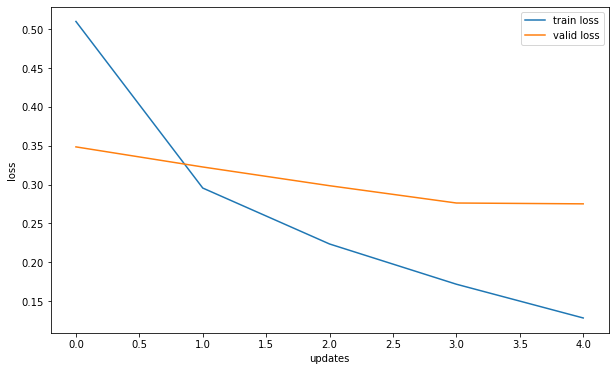

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

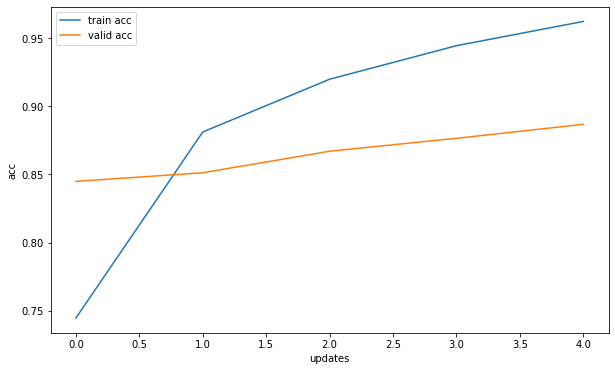

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [49]:
model.load_state_dict(torch.load('models/fasttext_CNN.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.255 | Test Acc: 89.53%


### Test on some random reviews

In [50]:
test_str = "This is Chaky.  This movie is really good good good"
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([68, 11,  0,  6,  0, 68, 24, 11, 79, 62, 62, 62], device='cuda:0')

In [51]:
text = text.reshape(1, -1)  #because batch_size is 1

In [52]:
text_length = torch.tensor([text.size(0)]).to(dtype=torch.int64)

In [53]:
text.shape

torch.Size([1, 12])

In [54]:
text_length.shape

torch.Size([1])

In [57]:
def predict(text, text_pipeline):
    model.eval()
    with torch.no_grad():
        output = model(text).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(output))
        return rounded_preds

In [58]:
predict(text, text_pipeline)  #quite accurate!!! try change to opposite

tensor([1.], device='cuda:0')

### Practice

- Try to use the conv1d and see whether it works
- Try to add more filter and see whether you can get the code right